# Randomised Training Set Tester

In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

import random

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            ax[i].axvline(time_split, color='black', ls='--')
            
def antiOverFitterScorer(y_train_pred, y_train_act, y_val_pred, y_val_act):
    train_score = -mean_squared_error(y_train_pred, y_train_act)
    val_score = -mean_squared_error(y_val_pred, y_val_act)
    score = ((train_score + val_score)/2) * val_score/train_score
    return score

In [2]:
sites_list = np.unique(['QDABBN0002',
  'QDABBS0002',
  'QDABBS0010',
  'QDACHC0003',
  'QDACYP0006',
  'QDACYP0018',
  'QDACYP0020',
  'QDACYP0022',
  'QDAEIU0005',
  'QDAGUP0006',
  'QDAGUP0009',
  'QDAGUP0019',
  'QDAGUP0021',
  'QDAMGD0002',
  'QDAMGD0023',
  'QDAMGD0024',
  'QDAMGD0025',
  'QDAMUL0002',
  'QDAMUL0003',
  'QDASEQ0004',
  'QDASSD0015', 
  'QDAEIU0010']) # QD 

In [4]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['Bryophyte', 'Chenopod', 'Cycad', 'Epiphyte',
                         'Fern', 'Forb', 'Fungus', 'Grass.tree', 'Heath.shrub', 
                         'Hummock.grass', 'Rush', 'Sedge', 'Shrub', 'Shrub.Mallee', 
                         'Tree.fern','Tree.Mallee', 'Tree.Palm', 'Tussock.grass', 'Vine']

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES # final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']

In [54]:
# Training and set set 
training_set = {}
test_set = {}
# 7 years is roughly 20% of the dataset (of n rows)
# i.e. 161 data points 
# A solution is take a random number of the lower bounds (l), such that l >= 0 and l < n - 161
# The upper bounds (u) is simply u = l + 161 

# Iterate through the site list 

period = 161

for site_location_name in sites_list:
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy().dropna(subset = FEATURES) # read and drop na
    site_merged.sort_values('time', inplace = True)
    site_merged.reset_index(inplace = True)
    print(site_merged.index)
    lower_bound = random.randrange(0, len(site_merged) - period, period)
    upper_bound = lower_bound + period
    
    
    #print((lower_bound, upper_bound))
    # get test set 
    test = site_merged[(site_merged.index < site_merged.index[upper_bound]) & (site_merged.index >= site_merged.index[lower_bound])]
    # get train set (note the selection condition is logically opposite to selection condition of the test set )
    train = site_merged[(site_merged.index >= site_merged.index[upper_bound]) | (site_merged.index < site_merged.index[lower_bound])]
    
    training_set[site_location_name] = train
    test_set[site_location_name] = test
    
training_merged = pd.concat(training_set).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
training_merged.sort_values('time', inplace = True)
training_merged.set_index('time', inplace = True)

test_merged = pd.concat(test_set).dropna(subset = FEATURES)
test_merged.sort_values('time', inplace = True)
test_merged.set_index('time', inplace = True)

RangeIndex(start=0, stop=804, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1)
(322, 483)
RangeIndex(start=0, stop=805, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1)
(0, 161)
RangeIndex(start=0, stop=804, step=1)
(161, 322)
RangeIndex(start=0, stop=806, step=1)
(644, 805)
RangeIndex(start=0, stop=805, step=1)
(483, 644)
RangeIndex(start=0, stop=804, step=1)
(322, 483)
RangeIndex(start=0, stop=806, step=1)
(483, 644)
RangeIndex(start=0, stop=806, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1)
(322, 483)
RangeIndex(start=0, stop=806, step=1)
(322, 483)
RangeIndex(start=0, stop=806, step=1)
(0, 161)
RangeIndex(start=0, stop=806, step=1)
(644, 805)
RangeIndex(start=0, stop=806, step=1)
(483, 644)
RangeIndex(start=0, stop=805, step=1)
(161, 322)
RangeIndex(start=0, stop=805, step=1)
(161, 322)
RangeIndex(start=0, stop=805, step=1)
(0, 161)
RangeIndex(start=0, stop=805, step=1

<Axes: xlabel='time'>

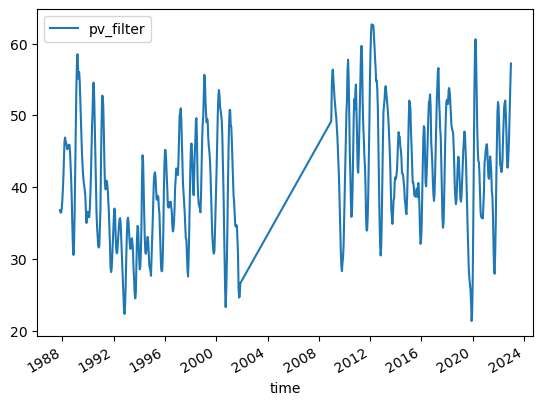

In [47]:
training_set['QDABBN0002'].plot(y = 'pv_filter')

<Axes: xlabel='time'>

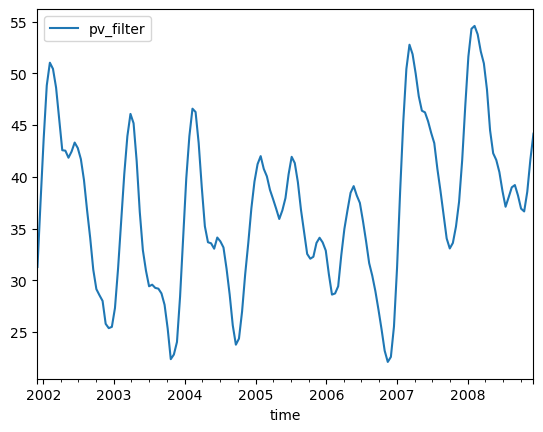

In [49]:
test_set['QDABBN0002'].plot(y = 'pv_filter')

In [ ]:
n_splits = 5
total = len(train)//n_splits
train_size = np.floor(total*0.7).astype(int)
test_size = total - train_size

cv_splits = []

for n in range(n_splits):
    train_idx = np.array([(number + n*total) for number in range(1,train_size +1)])
    test_idx = np.array([(number + train_idx.max()) for number in range(1, test_size + 1)])
    cv_splits.append((train_idx, test_idx))

Objective:

-> To generate a training set such that

    -> each site has a randomised time split such that its 80/20

In [5]:
time_split = '2015-12-01' # This aprox splits the dataset from 80/20
train = site_merged.iloc[site_merged.index <= time_split]
test = site_merged.iloc[site_merged.index > time_split]
random_state = 20240228

n_splits = 5
total = len(train)//n_splits
train_size = np.floor(total*0.7).astype(int)
test_size = total - train_size

cv_splits = []

for n in range(n_splits):
    train_idx = np.array([(number + n*total) for number in range(1,train_size +1)])
    test_idx = np.array([(number + train_idx.max()) for number in range(1, test_size + 1)])
    cv_splits.append((train_idx, test_idx))

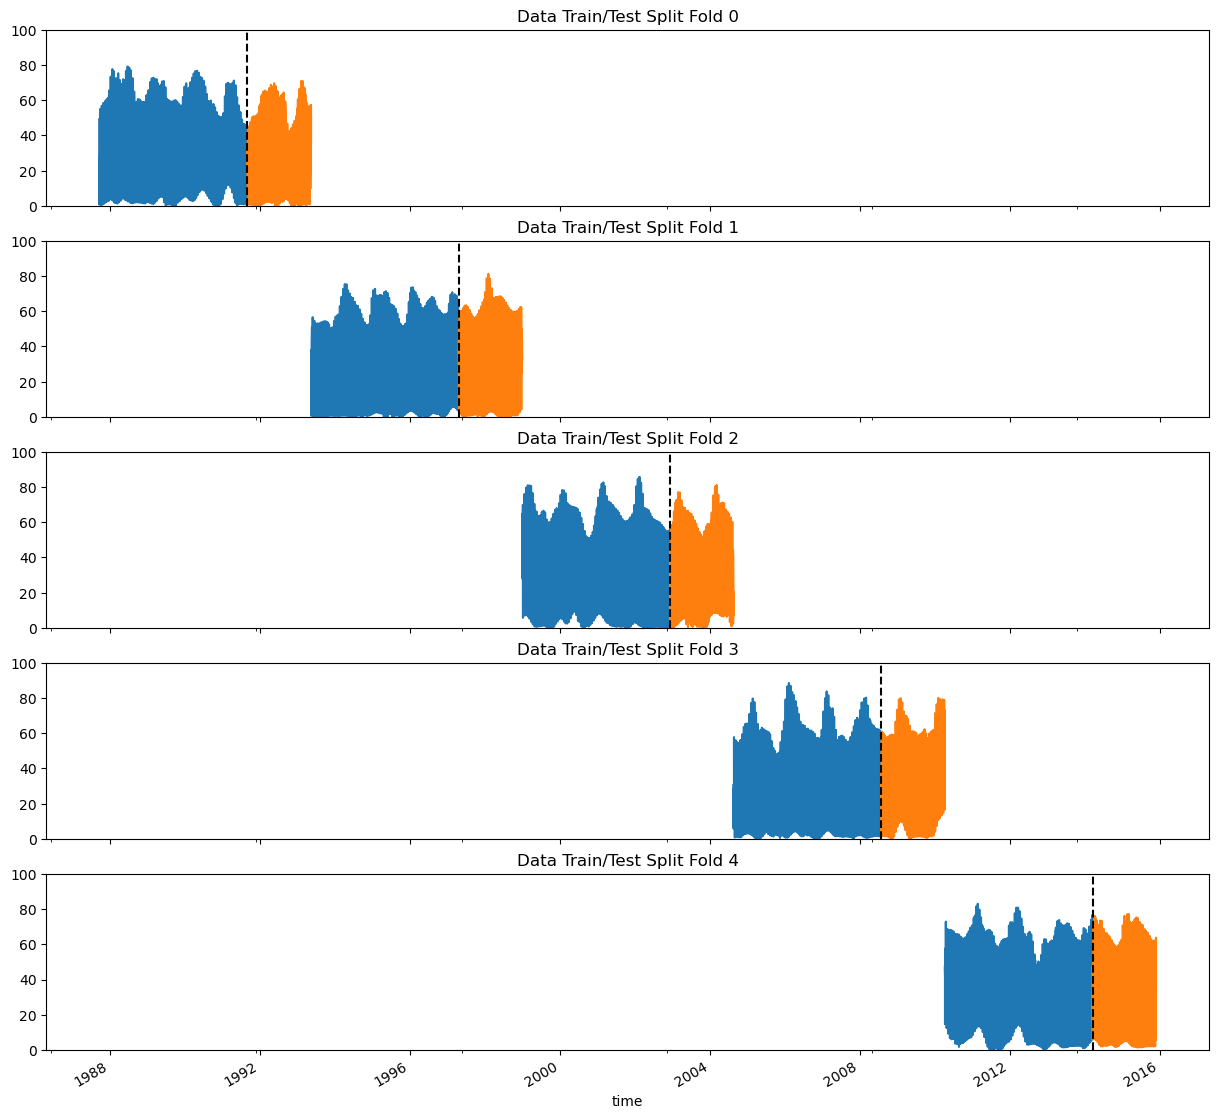

In [6]:
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in cv_splits: # split train into k-folds 
    train_f = train.iloc[train_idx]
    val_f = train.iloc[val_idx]
    train_f['pv_filter'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}', ylim = (0,100))
    val_f['pv_filter'].plot(ax=axs[fold],
                         label='Test Set', ylim = (0,100))
    axs[fold].axvline(val_f.index.min(), color='black', ls='--')
    fold += 1
plt.show()